In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil

* param layers : List of layers sizes with first element being the size of input layer
* param acts : list of activation functions for each layer with size one less than the size of layers. First element corresponds to the size of input layer and last layer corresponds to the output layer size
             * r - RELU
             * t - Tanh
             * s - Sigmoid
* iters : Maximum number of iterations for gradient descent
* mini_batc_size : Size to divide the input x into certain number of batches
* optimizer : Select an optimization train the model much better
            * mini_batch_size = 1 : Stochastic Gradient Descent
            * mini_batch_size > 1 : Batch Gradient Descent
            * rmsprop : Gradient Descent with Momentum
            * adam : Adaptive Moment Estimation for Gradient Descent
* plot_acc : Plots accuray at each epoch after training the model
* plot_des : Plots cost at each epoch after training the model

In [50]:
class DNN:
    
    def __init__(self, layers, acts=None, lr=0.001, optimizer=None, iters=2500, mini_batch_size=128,\
                 beta1=0.9, beta2=0.999, plot_acc=1, plot_descent=1):
        self.layers = layers
        self.acts = None
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = 1e-7
        self.iters = iters
        self.mbs = mini_batch_size
        self.optimizer = optimizer
        self.ptac, self.ptds = plot_acc, plot_descent
        self.x, self.xp, self.y, self.yp, self.mbm = None, None, None, None, None
        
        self.W, self.B, self.A, self.Z = {}, {}, {}, {}
        self.dw, self.db, self.dz = {}, {}, {}
        self.vdw, self.vdb, self.adw, self.adb, self.cvdw, self.cvdb, self.cadw, self.cadb = {}, {}, {}, {}, {}, {}, {}, {}
        self.mbx, self.mby, self.costs, self.acc = [], [], [], []
        
        if acts:
            self.acts = acts
        else:
            self.acts = (['r']*(len(self.layers)-2))+['s']
            
        self.activations = {'r': self.relu, 't': self.tanh, 's': self.sigmoid}
        self.diff_activations = {'r': self.diff_relu, 't': self.diff_tanh}
    
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def tanh(self, z):
        return np.tanh(z)
    
    def diff_tanh(self, z):
        return 1-np.square(self.tanh(z))
    
    def diff_relu(self, z):
        return np.where(z>0, 1, 0)
    
    def fit(self, x, y):
        self.x, self.xp = x.T, x
        self.y, self.yp = y.reshape((1, -1)), y.reshape((1, -1))
        self.m = self.x.shape[1]
        
        self.initialize_weights()
        self.create_mini_batches()
        self.optimize_weights()
        
        if self.ptds:
            plt.figure(1)
            plt.plot(self.costs, alpha=0.7, color='green', label='Gradient Descent')
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
            plt.legend()
            plt.grid(True)
            
        if self.ptac:
            plt.figure(2)
            plt.plot(self.acc, alpha=0.7, color='red', label='Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
        
    def predict(self, x):
        
        self.A['A0'] = x.T
        for i in range(1, len(self.layers)):
            self.Z['Z'+str(i)] = (self.W['W'+str(i)] @ self.A['A'+str(i-1)]) + self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
        self.predictions = np.round(self.A['A'+str(len(self.layers)-1)])
        
        return self.predictions
    
    def initialize_weights(self):
        
        for i in range(1, len(self.layers)):
            self.W['W'+str(i)] = np.random.random((self.layers[i], self.layers[i-1]))*np.sqrt(2/self.layers[i-1])
            self.B['B'+str(i)] = np.random.random((self.layers[i], 1))*0.001
            self.vdw['vdw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.vdb['vdb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.adw['adw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.adb['adb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.cvdw['cvdw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.cvdb['cvdb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
            self.cadw['cadw'+str(i)] = np.zeros_like(self.W['W'+str(i)])
            self.cadb['cadb'+str(i)] = np.zeros_like(self.B['B'+str(i)])
    
    def forward_propagation(self):
        for i in range(1, len(self.layers)):
            self.Z['Z'+str(i)] = (self.W['W'+str(i)] @ self.A['A'+str(i-1)]) + self.B['B'+str(i)]
            self.A['A'+str(i)] = self.activations[self.acts[i-1]](self.Z['Z'+str(i)])
            
    def backward_propagation(self):
        for i in range(1, len(self.layers))[::-1]:
            if i==len(self.layers)-1:
                self.dz['dz'+str(i)] = self.A['A'+str(i)] - self.y
            else:
                self.dz['dz'+str(i)] = (self.W['W'+str(i+1)].T @ self.dz['dz'+str(i+1)])\
                                        * self.diff_activations[self.acts[i-1]](self.Z['Z'+str(i)])
            self.dw['dw'+str(i)] = (self.dz['dz'+str(i)] @ self.A['A'+str(i-1)].T) / self.m
            self.db['db'+str(i)] = np.sum(self.dz['dz'+str(i)], axis=1, keepdims=True) / self.m
            
    def compute_cost(self):
        
        term1 = -self.y*np.log(self.A['A'+str(len(self.layers)-1)]+self.epsilon)
        term2 = -(1-self.y)*np.log(1-self.A['A'+str(len(self.layers)-1)]+self.epsilon)
        cost = np.sum(term1+term2)/self.m
        return cost
    
    def accuracy(self):
        preds = self.predict(self.xp)
        return (np.sum(preds==self.yp)/self.yp.size)*100
    
    def optimize_weights(self):
        for _ in range(1, self.iters+1):
            for x, y in zip(self.mbx, self.mby):
                self.x, self.y = x, y
                self.m = x.shape[1]
                self.A['A0'] = self.x
                self.forward_propagation()
                self.backward_propagation()
                for i in range(1, len(self.layers)):
                    if self.optimizer.lower()=='adam':
                        self.adam(_)
                        self.W['W'+str(i)] -= self.lr*\
                                            (self.cvdw['cvdw'+str(i)]/ np.sqrt(self.cadw['cadw'+str(i)] + self.epsilon))
                        self.B['B'+str(i)] -= self.lr*\
                                            (self.cvdb['cvdb'+str(i)]/ np.sqrt(self.cadb['cadb'+str(i)] + self.epsilon))
                    elif self.optimizer.lower()=='rmsprop':
                        self.momentum(_)
                        self.W['W'+str(i)] -= self.lr*self.cvdw['cvdw'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.cvdb['cvdb'+str(i)]
                    else:
                        self.W['W'+str(i)] -= self.lr*self.dw['dw'+str(i)]
                        self.B['B'+str(i)] -= self.lr*self.db['db'+str(i)]
            self.costs.append(self.compute_cost())
            self.acc.append(self.accuracy())
    
    def momentum(self, t):
        
        for i in range(1, len(self.layers)):
            self.vdw['vdw'+str(i)] = self.beta1*self.vdw['vdw'+str(i)] + (1-self.beta1)*(self.dw['dw'+str(i)])
            self.vdb['vdb'+str(i)] = self.beta1*self.vdb['vdb'+str(i)] + (1-self.beta1)*(self.db['db'+str(i)])
            self.cvdw['cvdw'+str(i)] = self.vdw['vdw'+str(i)] / (1-np.power(self.beta1, t))
            self.cvdb['cvdb'+str(i)] = self.vdb['vdb'+str(i)] / (1-np.power(self.beta1, t))
            
    def adam(self, t):
        
        self.momentum(t)
        for i in range(1, len(self.layers)):
            self.adw['adw'+str(i)] = self.beta2*self.adw['adw'+str(i)] + (1-self.beta2)*((self.dw['dw'+str(i)])**2)
            self.adb['adb'+str(i)] = self.beta2*self.adb['adb'+str(i)] + (1-self.beta2)*((self.db['db'+str(i)])**2)
            self.cadw['cadw'+str(i)] = self.adw['adw'+str(i)] / (1-np.power(self.beta2, t))
            self.cadb['cadb'+str(i)] = self.adb['adb'+str(i)] / (1-np.power(self.beta2, t))
            
    def create_mini_batches(self):
        start, end = 0, self.mbs
        if self.mbs<=self.x.shape[1]:
            for i in range(ceil(self.x.shape[1]/self.mbs)):
                if i==ceil(self.x.shape[1]/self.mbs)-1:
                    self.mbx.append(self.x[:, start:])
                    self.mby.append(self.y[:, start:])
                else:
                    self.mbx.append(self.x[:, start:end])
                    self.mby.append(self.y[:, start:end])
                start += self.mbs
                end += self.mbs
        else:
            self.mbx.append(self.x)
            self.mby.append(self.y)

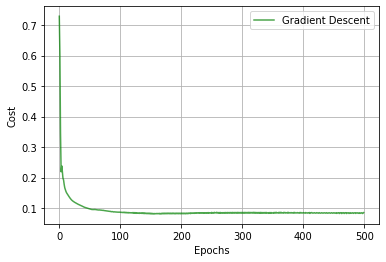

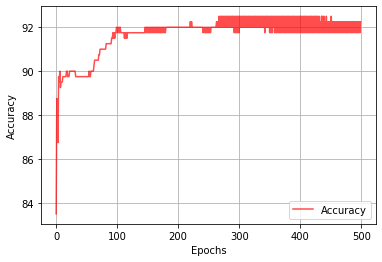

In [51]:
data = pd.read_csv('Social_Network_Ads.csv')
x = data.iloc[:, [2,3]].values
y = data.iloc[:, -1].values
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)
nn = DNN(layers=[2,5,3,2,1], iters=500, lr=0.05, mini_batch_size=128, optimizer='AdAm')
nn.fit(x, y)
# plt.plot(nn.costs)

In [53]:
nn.acc[-1]

92.25